In [12]:
import pandas as pd

data = pd.read_csv("SMS.tsv", sep="\t", skiprows=1, names=["label", "text"])

data['label'] = data['label'].map({'ham': 0, 'spam': 1})

X = data['text']
y = data['label']

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

vectorizer = CountVectorizer(lowercase=True, stop_words='english', min_df=2)
X_vectorized = vectorizer.fit_transform(X)

X_train_vectorized, X_test_vectorized, y_train, y_test = train_test_split(
    X_vectorized,
    y,
    test_size=0.3,
)

feature_names = np.array(vectorizer.get_feature_names_out())

In [33]:
from sklearn.linear_model import LogisticRegression

class CustomEmbeddedSelector:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        self.feature_importances_ = np.abs(self.model.coef_).flatten()

    def transform(self, X, k=30):
        top_indeces = np.argsort(self.feature_importances_)[-k:]

        return top_indeces


embedded_selector_custom = CustomEmbeddedSelector(
    LogisticRegression(penalty='l1', solver='liblinear'),
)
embedded_selector_custom.fit(X_train_vectorized, y_train)
embedded_support_custom = embedded_selector_custom.transform(X_train_vectorized)
embedded_features_custom = feature_names[embedded_support_custom]

from sklearn.feature_selection import SelectFromModel

model_embedded = LogisticRegression(penalty='l1', solver='liblinear')
sfm = SelectFromModel(model_embedded, max_features=30)
sfm.fit(X_train_vectorized, y_train)

embedded_support = sfm.get_support()
embedded_features = feature_names[embedded_support]

In [38]:
from sklearn.tree import DecisionTreeClassifier

class CustomWrapperSelector:
    def __init__(self, model, n_features_to_select):
        self.model = model
        self.n_features_to_select = n_features_to_select
        self.selected_features_ = []

    def fit(self, X, y):
        num_features = X.shape[1]
        remaining_features = set(range(num_features))

        while len(self.selected_features_) < self.n_features_to_select:
            best_feature = None
            best_score = -np.inf

            for feature in remaining_features:
                candidate_features = self.selected_features_ + [feature]
                self.model.fit(X[:, candidate_features], y)
                score = self.model.score(X[:, candidate_features], y)

                if score > best_score:
                    best_score = score
                    best_feature = feature

            if best_feature is not None:
                self.selected_features_.append(best_feature)
                remaining_features.remove(best_feature)

        return self

    def transform(self, X):
        return self.selected_features_


wrapper_selector_custom = CustomWrapperSelector(
    DecisionTreeClassifier(max_depth=7),
    n_features_to_select=30,
)
wrapper_selector_custom.fit(X_train_vectorized, y_train)
wrapper_support_custom = wrapper_selector_custom.transform(X_train_vectorized)
wrapper_features_custom = feature_names[wrapper_support_custom]


from sklearn.feature_selection import RFE

model_wrapper = DecisionTreeClassifier(max_depth=7)
rfe = RFE(model_wrapper, n_features_to_select=30)
rfe.fit(X_train_vectorized, y_train)

wrapper_support = rfe.get_support()
wrapper_features = feature_names[wrapper_support]

In [44]:
def custom_chi2_score(X, y):
    n_samples, n_features = X.shape
    unique_classes = np.unique(y)
    chi2_scores = np.zeros(n_features)

    for i in range(n_features):
        observed = np.array([X[y == c, i].sum() for c in unique_classes])
        total = observed.sum()
        expected = total * np.array([(y == c).sum() / n_samples for c in unique_classes])

        chi2_scores[i] = np.sum((observed - expected) ** 2 / (expected + 1e-10))

    return chi2_scores


class CustomFilterSelector:
    def __init__(self, score_func):
        self.score_func = score_func

    def fit(self, X, y):
        self.scores_ = self.score_func(X, y)
        return self

    def transform(self, X, k=30):
        top_indices = np.argsort(self.scores_)[-k:]
        return top_indices


filter_selector_custom = CustomFilterSelector(custom_chi2_score)
filter_selector_custom.fit(X_train_vectorized, y_train)
filter_support_custom = filter_selector_custom.transform(X_train_vectorized)
filter_features_custom = feature_names[filter_support_custom]


from sklearn.feature_selection import SelectKBest, mutual_info_classif

skb = SelectKBest(mutual_info_classif, k=30)
skb.fit(X_train_vectorized, y_train)
filter_support = skb.get_support()
filter_features = feature_names[filter_support]

In [42]:
print("Embedded method (custom):", embedded_features_custom)
print("Embedded method (library):", embedded_features)
print("Wrapper method (custom):", wrapper_features_custom)
print("Wrapper method (library):", wrapper_features)
print("Filter method (custom):", filter_features_custom)
print("Filter method (library):",  filter_features)

Embedded method (custom): ['order' 'freemsg' 'filthy' 'urgent' 'sms' 'won' 'fullonsms' 'cost'
 'video' 'service' 'landline' 'www' 'awarded' 'customer' '100' 'chat'
 'txt' 'min' 'reveal' 'dating' 'arsenal' '88066' 'voicemail' 'ladies'
 'ringtone' 'tone' '50' '150p' 'uk' 'claim']
Embedded method (library): ['100' '150p' '50' '88066' 'admirer' 'arsenal' 'awarded' 'chat' 'claim'
 'cost' 'customer' 'dating' 'filthy' 'freemsg' 'fullonsms' 'ladies'
 'landline' 'min' 'mobile' 'ringtone' 'service' 'sms' 'tone' 'txt' 'uk'
 'urgent' 'video' 'voicemail' 'won' 'www']
Wrapper method (custom): ['txt' 'claim' 'www' 'mobile' '150p' '16' 'service' 'bak' 'later' 'hi'
 'finish' 'id' 'left' 'speak' '00' '000' '008704050406' '01223585334' '02'
 '0207' '02073162414' '021' '03' '04' '05' '050703' '0578' '06' '07'
 '07123456789']
Wrapper method (library): ['150p' '150p16' '150pm' '150ppermesssubscription' '150ppm' '153' '16'
 '169' '18' 'accounts' 'bak' 'camera' 'claim' 'college' 'did' 'free'
 'nokia' 'service

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

selections = {
    'Embedded': embedded_features,
    'Wrapper': wrapper_features,
    'Filter': filter_features,
    'Custom Embedded': embedded_features_custom,
    'Custom Wrapper': wrapper_features_custom,
    'Custom Filter': filter_features_custom
}

classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(kernel='linear')
}

results = {}

for selection_name, selection in selections.items():
    for name, classifier in classifiers.items():
        classifier.fit(X_train_vectorized, y_train)
        y_pred = classifier.predict(X_test_vectorized)
        accuracy_before = accuracy_score(y_test, y_pred)

        mask = np.isin(feature_names, selection)
        X_train_selected = X_train_vectorized[:, mask]
        X_test_selected = X_test_vectorized[:, mask]

        classifier.fit(X_train_selected, y_train)
        y_pred_selected = classifier.predict(X_test_selected)
        accuracy_after = accuracy_score(y_test, y_pred_selected)

        results[selection_name + "&" + name] = (accuracy_before, accuracy_after)

for name, (before, after) in results.items():
    print(f"{name}: Before = {before:.4f}, After = {after:.4f}")


Embedded&LogisticRegression: Before = 0.9803, After = 0.9551
Embedded&RandomForest: Before = 0.9773, After = 0.9533
Embedded&SVM: Before = 0.9815, After = 0.9557
Wrapper&LogisticRegression: Before = 0.9803, After = 0.9486
Wrapper&RandomForest: Before = 0.9791, After = 0.9516
Wrapper&SVM: Before = 0.9815, After = 0.9480
Filter&LogisticRegression: Before = 0.9803, After = 0.9528
Filter&RandomForest: Before = 0.9791, After = 0.9587
Filter&SVM: Before = 0.9815, After = 0.9569
Custom Embedded&LogisticRegression: Before = 0.9803, After = 0.9522
Custom Embedded&RandomForest: Before = 0.9791, After = 0.9551
Custom Embedded&SVM: Before = 0.9815, After = 0.9510
Custom Wrapper&LogisticRegression: Before = 0.9803, After = 0.9480
Custom Wrapper&RandomForest: Before = 0.9797, After = 0.9486
Custom Wrapper&SVM: Before = 0.9815, After = 0.9498
Custom Filter&LogisticRegression: Before = 0.9803, After = 0.9545
Custom Filter&RandomForest: Before = 0.9797, After = 0.9599
Custom Filter&SVM: Before = 0.9815

In [58]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

def clasterize_and_stuff(X_train_, X_test_, y_test_, selection):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_train_)

    predictions_before = kmeans.predict(X_test_)
    silhouette_before = silhouette_score(X_test_, predictions_before)
    ari_before = adjusted_rand_score(y_test_, predictions_before)

    mask = np.isin(feature_names, selection)
    X_train_selected = X_train_vectorized[:, mask]
    X_test_selected = X_test_vectorized[:, mask]

    kmeans.fit(X_train_selected)
    predictions_after = kmeans.predict(X_test_selected)
    silhouette_after = silhouette_score(X_test_selected, predictions_after)
    ari_after = adjusted_rand_score(y_test_, predictions_after)

    print(f"Before: silhouette={silhouette_before:.2f}, ari={ari_before:.2f}")
    print(f"After: silhouette={silhouette_after:.2f}, ari={ari_after:.2f}")


clasterize_and_stuff(X_train_vectorized, X_test_vectorized, y_test, wrapper_features)
clasterize_and_stuff(X_train_vectorized, X_test_vectorized, y_test, wrapper_features_custom)

Before: silhouette=0.26, ari=0.08
After: silhouette=0.78, ari=0.22
Before: silhouette=0.44, ari=-0.00
After: silhouette=0.80, ari=0.20


In [59]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_clusters(X, y_real, cluster_labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], cmap='viridis', alpha=0.5, c=y_real)
    plt.title(title + ' (real)')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], cmap='viridis', alpha=0.5, c=cluster_labels)
    plt.title(title + ' (KMeans)')
    plt.show()


kmeans_before = KMeans(n_clusters=2)
kmeans_after = KMeans(n_clusters=2)

mask = np.isin(feature_names, wrapper_features_custom)
X_test_selected = X_test_vectorized[:, mask]

clusters_before = kmeans_before.fit_predict(X_test_vectorized)
clusters_after = kmeans_after.fit_predict(X_test_selected)

pca_before = PCA(n_components=2, random_state=42)
pca_after = PCA(n_components=2, random_state=42)

X_pca_before = pca_before.fit_transform(X_test_vectorized)
X_pca_after = pca_after.fit_transform(X_test_selected)

tsne_before = TSNE(n_components=2, init='random', random_state=42)
tsne_after = TSNE(n_components=2, init='random', random_state=42)

X_tsne_before = tsne_before.fit_transform(X_test_vectorized)
X_tsne_after = tsne_after.fit_transform(X_test_selected)

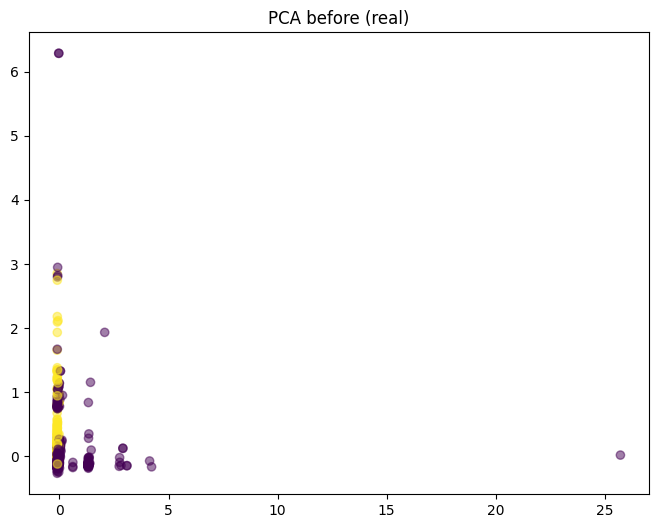

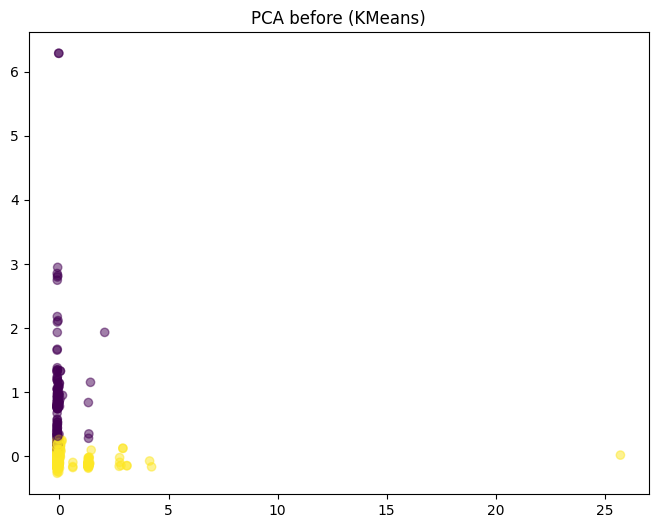

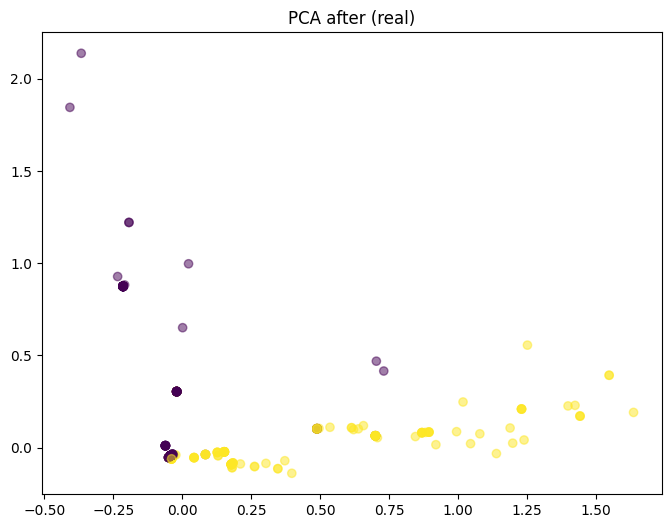

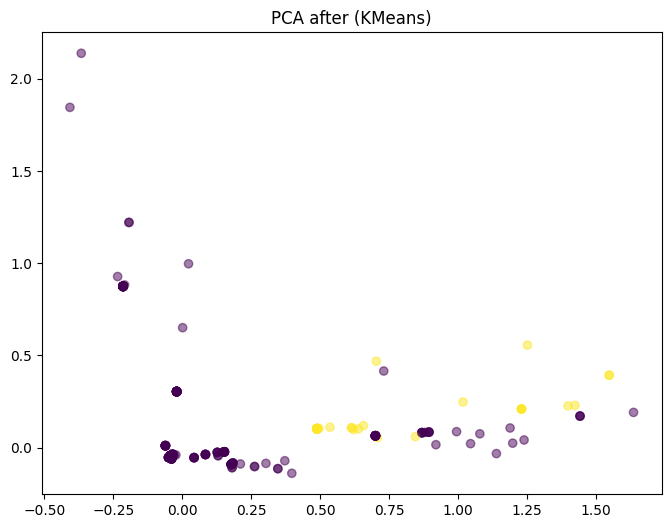

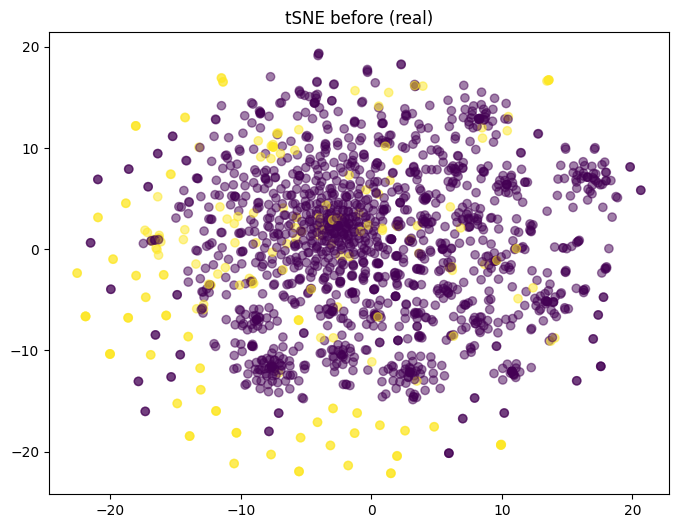

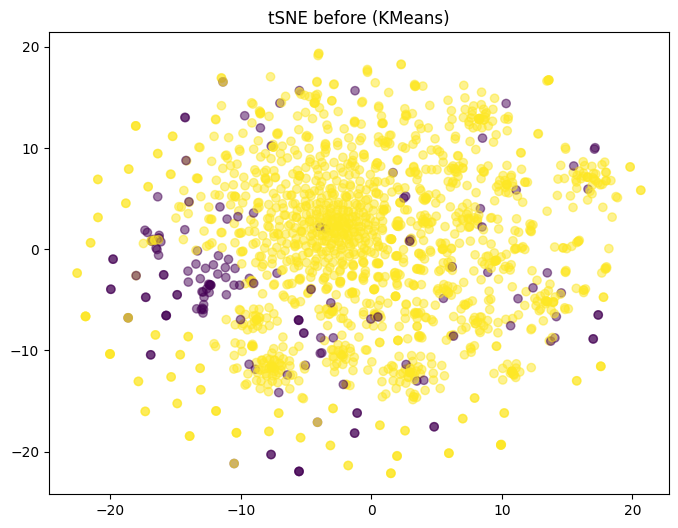

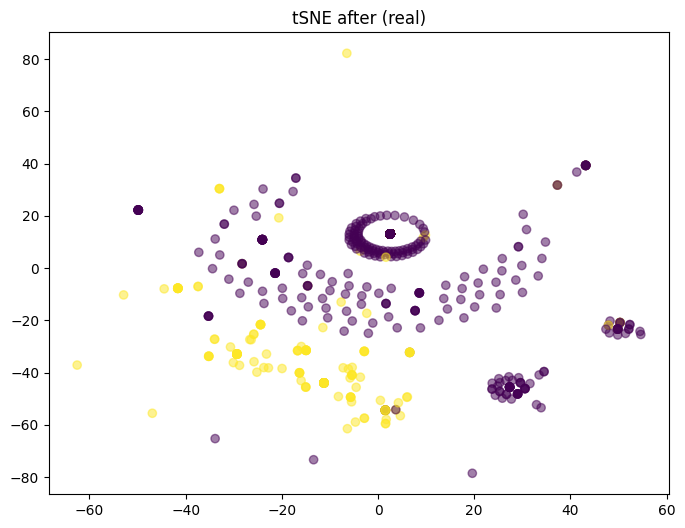

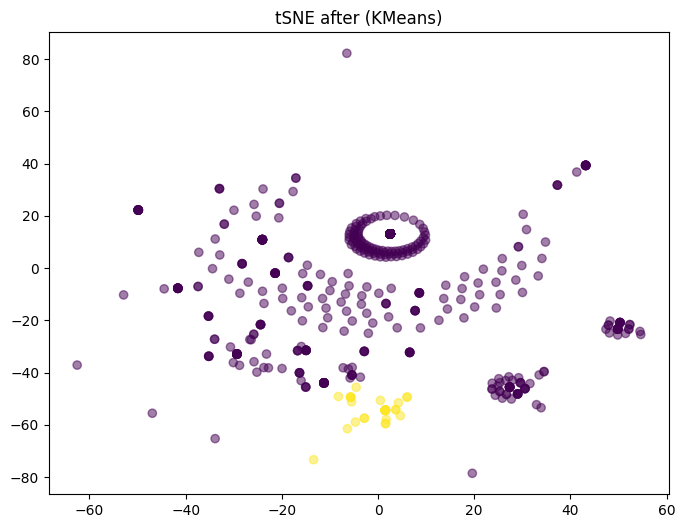

In [60]:
plot_clusters(X_pca_before, y_test, clusters_before, 'PCA before')
plot_clusters(X_pca_after, y_test, clusters_after, 'PCA after')

plot_clusters(X_tsne_before, y_test, clusters_before, 'tSNE before')
plot_clusters(X_tsne_after, y_test, clusters_after, 'tSNE after')